In [11]:
import argparse
import json
import logging
import pickle
import wandb

import matplotlib.pyplot as plt
import seaborn as sns
import glob
import pandas as pd
import os
import numpy as np
import copy
from pprint import pprint

In [12]:
import matplotlib
matplotlib.rcParams.update(
    {
        "figure.dpi": 150,
        "font.size": 20,
    }
)
matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42

In [13]:
api = wandb.Api()

In [14]:
def load_groups(group_and_keys, relabel_dict, x_range, extra_filter):
    all_interp_data = []
    for group, x_key, y_key in group_and_keys:
        total_filters = {
            "$and": [
                {"group": group},
                {"$not": {"tags": "exclude-from-paper"}},
                extra_filter,
            ]
        }
        pprint(total_filters)
        runs = api.runs(
            path="resl-mixppo/stabilized-rl",
            filters=total_filters,
        )
        print(f"Got {len(runs)} runs for group {group}")
        x_vals = np.linspace(x_range[0], x_range[1], 1000)
        for r in runs:
            # h = r.history(samples=2000, keys=[x_key, y_key])
            h = pd.DataFrame(r.scan_history(keys=[x_key, y_key]))
            try:
                if np.max(h[x_key]) < 0.99 * x_range[1]:
                    print("Maximum x value of run", str(r), "is", np.max(h[x_key]))
                    continue
                interp_y = np.interp(x_vals, h[x_key], h[y_key])
            except KeyError:
                print("Could not get keys in run", r)
                print(h)
            else:
                all_interp_data.append(
                    pd.DataFrame.from_dict(
                        {
                            relabel_dict.get(x_key, x_key): x_vals,
                            relabel_dict.get(y_key, y_key): interp_y,
                            relabel_dict.get("group", "group"): relabel_dict.get(
                                group, group
                            ),
                            "run": str(r),
                        }
                    )
                )
    return pd.concat(all_interp_data, ignore_index=True)

In [15]:
env = "HalfCheetah-v2"
group_and_keys = [
    ("xppo_single_step", "global_step", "rollout/ep_rew_mean"),
    ("baseline_ppo", "global_step", "rollout/ep_rew_mean"),
]
relabels = {
    "xppo-512-5": "xPPO",
    "baseline_ppo": "PPO-clip",
    "xppo10m-512-5": "xPPO",
    "xppo_single_step": "xPPO",
    "baseline_ppo_10m": "PPO-clip",
    "global_step": "Total Environment Steps",
    "rollout/ep_rew_mean": "Average Episode Reward",
    "group": "Algorithm",
}
all_data = load_groups(
    group_and_keys,
    relabels,
    (0, 3e6),
    {
        "$and": [
            {"config.env": env},
            {"$or": [{"tags": {"$in": ['paper']}}, {"state": "finished"}, {"state": "running"}]},
        ]
    },
)

{'$and': [{'group': 'xppo_single_step'},
          {'$not': {'tags': 'exclude-from-paper'}},
          {'$and': [{'config.env': 'HalfCheetah-v2'},
                    {'$or': [{'tags': {'$in': ['paper']}},
                             {'state': 'finished'},
                             {'state': 'running'}]}]}]}
Got 19 runs for group xppo_single_step


Maximum x value of run <Run resl-mixppo/stabilized-rl/3skaxz59 (crashed)> is 1937408.0
Maximum x value of run <Run resl-mixppo/stabilized-rl/upbbwt40 (crashed)> is 1945600.0
Maximum x value of run <Run resl-mixppo/stabilized-rl/ofnwff0r (crashed)> is 1970176.0
{'$and': [{'group': 'baseline_ppo'},
          {'$not': {'tags': 'exclude-from-paper'}},
          {'$and': [{'config.env': 'HalfCheetah-v2'},
                    {'$or': [{'tags': {'$in': ['paper']}},
                             {'state': 'finished'},
                             {'state': 'running'}]}]}]}
Got 8 runs for group baseline_ppo


/tmp/ipykernel_949149/76089687.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(


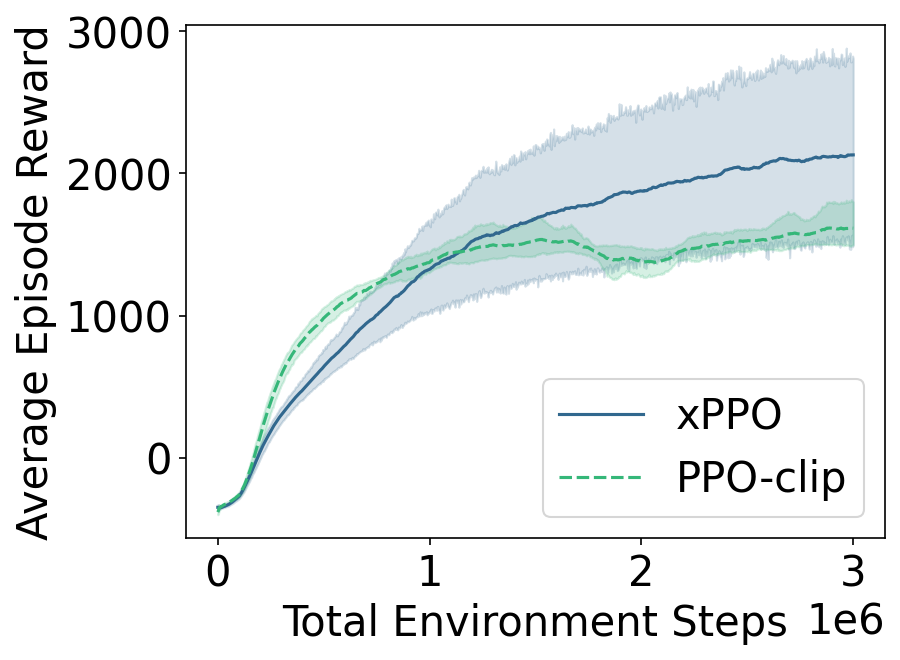

In [16]:
sns.lineplot(
    data=all_data,
    x="Total Environment Steps",
    y="Average Episode Reward",
    hue="Algorithm",
    ci=95,
    style="Algorithm",
    palette="viridis",
)
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig(f"xppo_vs_ppo_{env}.pdf")

{'$and': [{'group': 'xppo_single_step'},
          {'$not': {'tags': 'exclude-from-paper'}},
          {'$and': [{'config.env': 'Hopper-v2'},
                    {'$or': [{'tags': {'$in': ['paper']}},
                             {'state': 'finished'},
                             {'state': 'running'}]}]}]}


Got 19 runs for group xppo_single_step
Maximum x value of run <Run resl-mixppo/stabilized-rl/uqut2cvl (crashed)> is 1830912.0
Maximum x value of run <Run resl-mixppo/stabilized-rl/5bpkuo7z (crashed)> is 1966080.0
Maximum x value of run <Run resl-mixppo/stabilized-rl/dm8nik3u (crashed)> is 1986560.0
{'$and': [{'group': 'baseline_ppo_10m'},
          {'$not': {'tags': 'exclude-from-paper'}},
          {'$and': [{'config.env': 'Hopper-v2'},
                    {'$or': [{'tags': {'$in': ['paper']}},
                             {'state': 'finished'},
                             {'state': 'running'}]}]}]}
Got 13 runs for group baseline_ppo_10m


/tmp/ipykernel_949149/712580384.py:17: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(


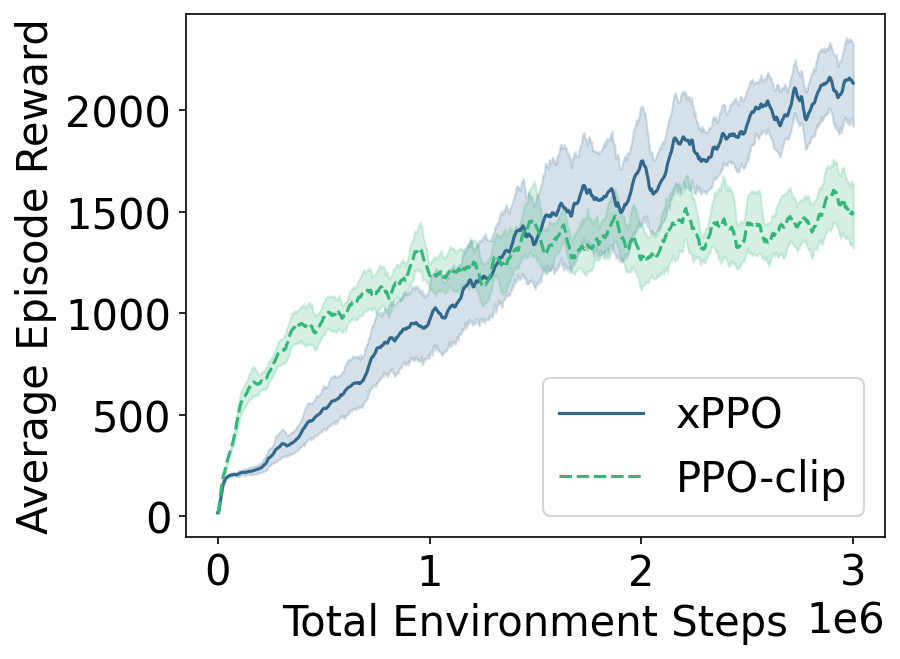

In [17]:
env = "Hopper-v2"
group_and_keys = [
    ("xppo_single_step", "global_step", "rollout/ep_rew_mean"),
    ("baseline_ppo_10m", "global_step", "rollout/ep_rew_mean"),
]
all_data = load_groups(
    group_and_keys,
    relabels,
    (0, 3e6),
    {
        "$and": [
            {"config.env": env},
            {"$or": [{"tags": {"$in": ['paper']}}, {"state": "finished"}, {"state": "running"}]},
        ]
    },
)
sns.lineplot(
    data=all_data,
    x="Total Environment Steps",
    y="Average Episode Reward",
    hue="Algorithm",
    ci=95,
    style="Algorithm",
    palette="viridis",
)
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig(f"xppo_vs_ppo_{env}.pdf")

{'$and': [{'group': 'xppo_single_step'},
          {'$not': {'tags': 'exclude-from-paper'}},
          {'$and': [{'config.env': 'Walker2d-v2'},
                    {'$or': [{'tags': {'$in': ['paper']}},
                             {'state': 'finished'},
                             {'state': 'running'}]}]}]}
Got 20 runs for group xppo_single_step
Maximum x value of run <Run resl-mixppo/stabilized-rl/ghkheu6s (crashed)> is 1904640.0
Maximum x value of run <Run resl-mixppo/stabilized-rl/zc7n2hta (crashed)> is 1929216.0
Maximum x value of run <Run resl-mixppo/stabilized-rl/cvuu9tur (crashed)> is 1937408.0
Maximum x value of run <Run resl-mixppo/stabilized-rl/xe208b9l (crashed)> is 1961984.0
{'$and': [{'group': 'baseline_ppo_10m'},
          {'$not': {'tags': 'exclude-from-paper'}},
          {'$and': [{'config.env': 'Walker2d-v2'},
                    {'$or': [{'tags': {'$in': ['paper']}},
                             {'state': 'finished'},
                             {'state': 'running

/tmp/ipykernel_949149/739370416.py:17: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(


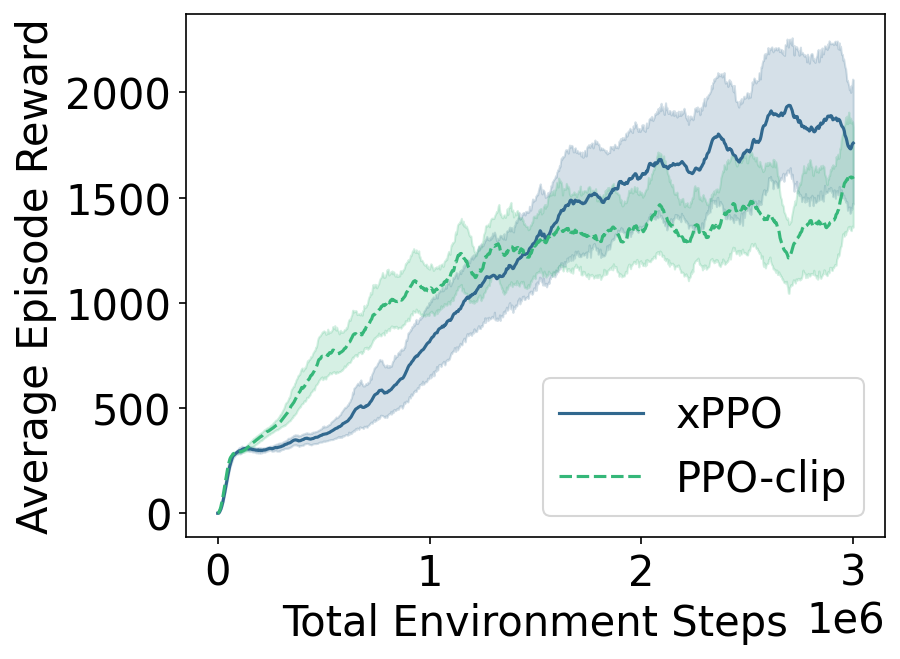

In [18]:
env = "Walker2d-v2"
group_and_keys = [
    ("xppo_single_step", "global_step", "rollout/ep_rew_mean"),
    ("baseline_ppo_10m", "global_step", "rollout/ep_rew_mean"),
]
all_data = load_groups(
    group_and_keys,
    relabels,
    (0, 3e6),
    {
        "$and": [
            {"config.env": env},
            {"$or": [{"tags": {"$in": ['paper']}}, {"state": "finished"}, {"state": "running"}]},
        ]
    },
)
sns.lineplot(
    data=all_data,
    x="Total Environment Steps",
    y="Average Episode Reward",
    hue="Algorithm",
    ci=95,
    style="Algorithm",
    palette="viridis",
)
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig(f"xppo_vs_ppo_{env}.pdf")

In [19]:
all_data[all_data["Total Environment Steps"] == 0]

,Total Environment Steps,Average Episode Reward,Algorithm,run
0,0.0,-0.017142,xPPO,<Run resl-mixppo/stabilized-rl/zfi1eaua (finis...
1000,0.0,0.223173,xPPO,<Run resl-mixppo/stabilized-rl/atc16gq2 (finis...
2000,0.0,-0.025584,xPPO,<Run resl-mixppo/stabilized-rl/jc3xrvb5 (finis...
3000,0.0,-0.553362,xPPO,<Run resl-mixppo/stabilized-rl/n46d2mes (finis...
4000,0.0,-0.913248,xPPO,<Run resl-mixppo/stabilized-rl/ay2atybb (finis...
5000,0.0,-0.367861,xPPO,<Run resl-mixppo/stabilized-rl/19nzjjv0 (finis...
6000,0.0,-1.767762,xPPO,<Run resl-mixppo/stabilized-rl/jkmj58ah (finis...
7000,0.0,-0.377784,xPPO,<Run resl-mixppo/stabilized-rl/xjem52av (finis...
8000,0.0,-0.913248,xPPO,<Run resl-mixppo/stabilized-rl/hfsts37x (crash...
9000,0.0,-0.367861,xPPO,<Run resl-mixppo/stabilized-rl/yaw4m35y (crash...


In [20]:
list(
    api.runs(
        path="resl-mixppo/stabilized-rl",
        filters={
            "$and": [
                {"group": "baseline_ppo_10m"},
                {"config.env": "Walker2d-v2"},
                {"tags": "paper"},
            ]
        },
    )
)

[<Run resl-mixppo/stabilized-rl/ch39g5up (killed)>,
 <Run resl-mixppo/stabilized-rl/ortt208y (killed)>,
 <Run resl-mixppo/stabilized-rl/dgwj3lpb (killed)>,
 <Run resl-mixppo/stabilized-rl/dtbl0d2c (killed)>,
 <Run resl-mixppo/stabilized-rl/ew7jz1q2 (finished)>,
 <Run resl-mixppo/stabilized-rl/7ahrebvs (finished)>,
 <Run resl-mixppo/stabilized-rl/gsyqyjjy (finished)>]

In [21]:
list(
    api.runs(
        path="resl-mixppo/stabilized-rl",
        filters={
            "$and": [
                {"group": "baseline_ppo_10m"},
                {"$not": {"tags": "exclude-from-paper"}},
                {
                    "$and": [
                        {"config.env": "Walker2d-v2"},
                        {
                            "$or": [
                                {"tags": "paper"},
                                {"state": "finished"},
                                {"state": "running"},
                            ]
                        },
                    ]
                },
            ]
        },
    )
)

[<Run resl-mixppo/stabilized-rl/zk39gpb1 (finished)>,
 <Run resl-mixppo/stabilized-rl/u2wlu7pf (finished)>,
 <Run resl-mixppo/stabilized-rl/mq23oopk (finished)>,
 <Run resl-mixppo/stabilized-rl/t3grkzqr (finished)>,
 <Run resl-mixppo/stabilized-rl/p9t42l73 (finished)>,
 <Run resl-mixppo/stabilized-rl/cxgvewnp (finished)>,
 <Run resl-mixppo/stabilized-rl/l8f1tl6v (finished)>,
 <Run resl-mixppo/stabilized-rl/fluigu9s (finished)>,
 <Run resl-mixppo/stabilized-rl/n4bnopdn (finished)>,
 <Run resl-mixppo/stabilized-rl/ch39g5up (killed)>,
 <Run resl-mixppo/stabilized-rl/ortt208y (killed)>,
 <Run resl-mixppo/stabilized-rl/dgwj3lpb (killed)>,
 <Run resl-mixppo/stabilized-rl/dtbl0d2c (killed)>,
 <Run resl-mixppo/stabilized-rl/ew7jz1q2 (finished)>,
 <Run resl-mixppo/stabilized-rl/7ahrebvs (finished)>,
 <Run resl-mixppo/stabilized-rl/gsyqyjjy (finished)>]

In [22]:
env = "Walker2d-v2"
group_and_keys = [
    ("xppo_single_step", "global_step", "train/mean_second_penalty_loops"),
    ("xppo_single_step", "global_step", "train/max_second_penalty_loops"),
]
all_data = load_groups(
    group_and_keys,
    relabels,
    (0, 3e6),
    {
        "$and": [
            {"config.env": env},
            {"$or": [{"tags": {"$in": ['paper']}}, {"state": "finished"}, {"state": "running"}]},
        ]
    },
)

{'$and': [{'group': 'xppo_single_step'},
          {'$not': {'tags': 'exclude-from-paper'}},
          {'$and': [{'config.env': 'Walker2d-v2'},
                    {'$or': [{'tags': {'$in': ['paper']}},
                             {'state': 'finished'},
                             {'state': 'running'}]}]}]}
Got 20 runs for group xppo_single_step
Maximum x value of run <Run resl-mixppo/stabilized-rl/ghkheu6s (crashed)> is 1904640.0
Maximum x value of run <Run resl-mixppo/stabilized-rl/zc7n2hta (crashed)> is 1929216.0
Maximum x value of run <Run resl-mixppo/stabilized-rl/cvuu9tur (crashed)> is 1937408.0
Maximum x value of run <Run resl-mixppo/stabilized-rl/xe208b9l (crashed)> is 1961984.0
{'$and': [{'group': 'xppo_single_step'},
          {'$not': {'tags': 'exclude-from-paper'}},
          {'$and': [{'config.env': 'Walker2d-v2'},
                    {'$or': [{'tags': {'$in': ['paper']}},
                             {'state': 'finished'},
                             {'state': 'running

In [23]:
data_fixup = pd.DataFrame.from_dict({
    "Total Environment Steps": all_data["Total Environment Steps"],
    "Second Phase Loop Iterations": np.where(np.isnan(all_data["train/mean_second_penalty_loops"]),
                                             all_data["train/max_second_penalty_loops"] - 1,
                                             all_data["train/mean_second_penalty_loops"] - 1), # We log each attempt to loop, including the last one
#     "Second Phase Loop Iterations": all_data["train/max_second_penalty_loops"] - 1,
    "Iterations": np.where(np.isnan(all_data["train/mean_second_penalty_loops"]), "Max", "Mean"),
#     "Mean Iterations": ~np.isnan(all_data["train/mean_second_penalty_loops"]),
#     "Max Iterations": ~np.isnan(all_data["train/max_second_penalty_loops"]),
})

/tmp/ipykernel_949149/2169059143.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(


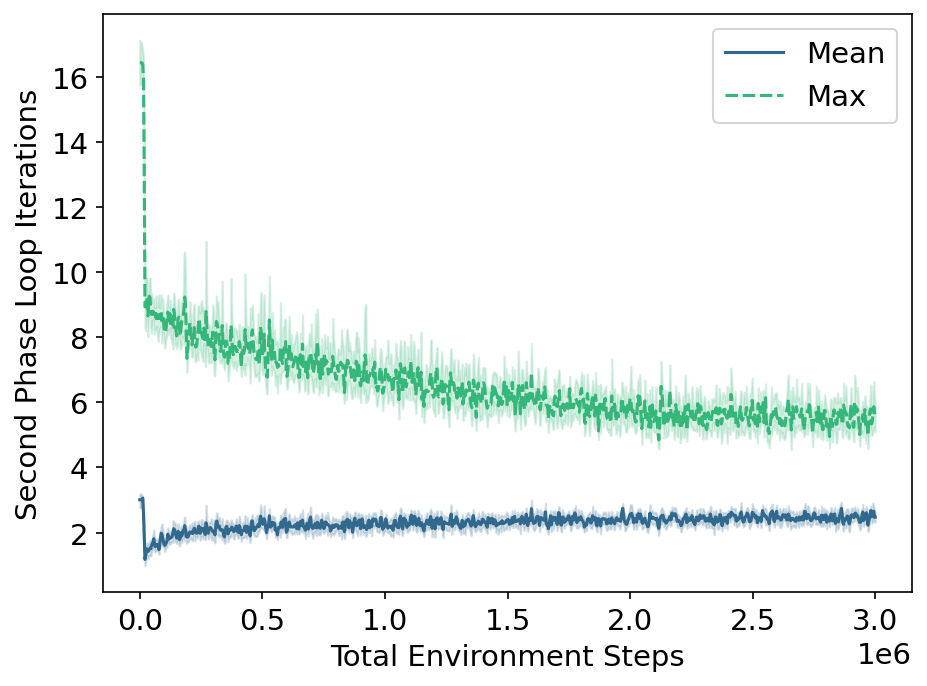

In [24]:
matplotlib.rcParams["font.size"] = 14
sns.lineplot(
    data=data_fixup,
    x="Total Environment Steps",
    y="Second Phase Loop Iterations",
    hue="Iterations",
    ci=95,
    style="Iterations",
    palette="viridis",
)
plt.legend(loc="upper right")
plt.tight_layout()
plt.savefig(f"mean_and_max_second_loops_{env}.pdf")

{'$and': [{'group': 'xppo_single_step'},
          {'$not': {'tags': 'exclude-from-paper'}},
          {'$and': [{'config.env': 'Walker2d-v2'},
                    {'$or': [{'tags': {'$in': ['paper']}},
                             {'state': 'finished'},
                             {'state': 'running'}]}]}]}
Got 20 runs for group xppo_single_step
Maximum x value of run <Run resl-mixppo/stabilized-rl/ghkheu6s (crashed)> is 1904640.0
Maximum x value of run <Run resl-mixppo/stabilized-rl/zc7n2hta (crashed)> is 1929216.0
Maximum x value of run <Run resl-mixppo/stabilized-rl/cvuu9tur (crashed)> is 1937408.0
Maximum x value of run <Run resl-mixppo/stabilized-rl/xe208b9l (crashed)> is 1961984.0
{'$and': [{'group': 'baseline_ppo_10m'},
          {'$not': {'tags': 'exclude-from-paper'}},
          {'$and': [{'config.env': 'Walker2d-v2'},
                    {'$or': [{'tags': {'$in': ['paper']}},
                             {'state': 'finished'},
                             {'state': 'running

/tmp/ipykernel_949149/443731280.py:27: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(


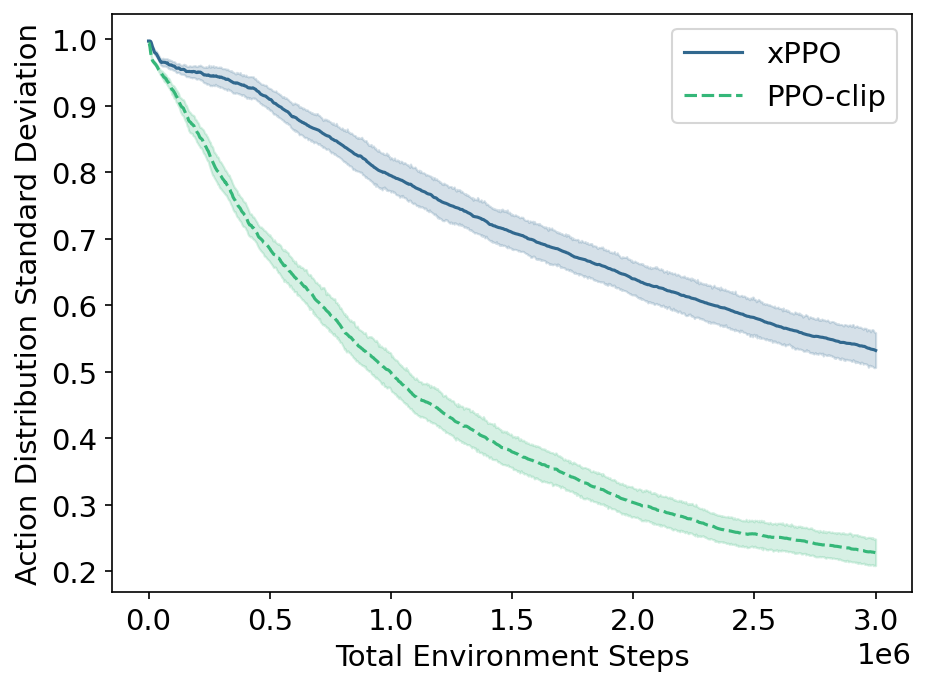

In [25]:
env = "Walker2d-v2"
group_and_keys = [
    ("xppo_single_step", "global_step", "train/std"),
    ("baseline_ppo_10m", "global_step", "train/std"),
]
relabels = {
    "xppo-512-5": "xPPO",
    "baseline_ppo": "PPO-clip",
    "xppo10m-512-5": "xPPO",
    "xppo_single_step": "xPPO",
    "baseline_ppo_10m": "PPO-clip",
    "global_step": "Total Environment Steps",
    "train/std": "Action Distribution Standard Deviation",
    "group": "Algorithm",
}
all_data = load_groups(
    group_and_keys,
    relabels,
    (0, 3e6),
    {
        "$and": [
            {"config.env": env},
            {"$or": [{"tags": {"$in": ['paper']}}, {"state": "finished"}, {"state": "running"}]},
        ]
    },
)
sns.lineplot(
    data=all_data,
    x="Total Environment Steps",
    y="Action Distribution Standard Deviation",
    hue="Algorithm",
    ci=95,
    style="Algorithm",
    palette="viridis",
)
plt.legend(loc="upper right")
plt.tight_layout()
plt.savefig(f"xppo_vs_ppo_std_dev_{env}.pdf")